### MDSI Advanced Machine Learning Applications

Student: Ivan Cheung

Assignment: Kaggle 1


GitHub repo: https://github.com/ivanutsmdsi/amla2023

In [91]:
import pandas as pd
import numpy as np
from sklearn.datasets import make_classification, load_breast_cancer
from collections import Counter
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder   ## for normalising the feature data
from sklearn.model_selection import train_test_split              ## making test/train splits, for producing AUROC score?
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from joblib import dump
from imblearn.over_sampling import SMOTE

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as imbpipeline
import seaborn as sb

In [100]:
## Load raw data into dataframe
df = pd.read_csv('../data/raw/train.csv', low_memory=False)

In [9]:
## PREPROCESSING FUNCTIONS

## create a function to remove the corrupt columns and return a clean df
def remove_unwanted_cols(df):
    # ftr - no description given, removed from feature analysis
    # yr - player year details are descriptive, need to vectorise in future modelling
    # ht - player height data has been corrupted
    # num - payer number not relevant as a feature
    # pfr - no description given, removed from feature analysis
    # type - metadata field not relevant as a feature
    # year - no longitudinal inclusion for feature modeling

    df_clean = df.drop(["ht", "yr", "num", "type" ,"year", "ftr", "pfr"], axis = 1)    
    ##df_clean = df.drop(["team", "conf", "ht", "yr", "num", "type" ,"year", "ftr", "pfr"], axis = 1)

    return df_clean

## fill null values with 0
## TO IMPROVE: not all columns should be filled with 0. Will need to reveiw this moving forward...
def fillna(df):
    df_clean = df.fillna(0)

    return df_clean


In [145]:
## Preprocessing dataframe 

# remove unwanted columns, previously identified as corrupt
df_clean = remove_unwanted_cols(df)

# apply placeholder values for nulls
df_clean = fillna(df_clean)


In [146]:
## pop columns into separate lists
target = df_clean.pop('drafted')
player_ids = df_clean.pop('player_id')

In [104]:
## Apply Standard Scalar and OHE (for team name and conference name)
## define the numeric cols and the category cols from the df_clean dataset
num_cols = list(df_clean.select_dtypes('number').columns)
cat_cols = list(set(df_clean.columns) - set(num_cols))


In [120]:
ohe = OneHotEncoder(sparse_output=False, drop='first')
features = ohe.fit_transform(df_clean[cat_cols])

## extract the cat attributes (the team names and conference names) from the training data
attribute_cats = ohe.categories_

In [123]:
numeric_transformer = Pipeline(steps= [("scaler", StandardScaler())])
categorical_transformer = Pipeline(steps= [("encoder", OneHotEncoder(sparse_output=False, drop='first', categories = attribute_cats,handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols),
    ]
)

In [124]:
clf = imbpipeline(
    steps=[("preprocessor", preprocessor), ("smote", SMOTE()) , ("classifier", LogisticRegression(max_iter=1000))]
)

In [131]:
clf.fit(df_clean, target)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['GP', 'Min_per', 'Ortg',
                                                   'usg', 'eFG', 'TS_per',
                                                   'ORB_per', 'DRB_per',
                                                   'AST_per', 'TO_per', 'FTM',
                                                   'FTA', 'FT_per', 'twoPM',
                                                   'twoPA', 'twoP_per', 'TPM',
                                                   'TPA', 'TP_per', 'blk_per',
                                                   'stl_per', 'porpag', 'adjoe',
                                                   'Rec_Rank', 'ast_tov',
                                                   'rimmade', 'rimmade_rimm...
                                                                                             array(['A10', 'ACC', 'AE', 'ASun', 'Amer', 'B10', 'B12', 'BE', 'BSky',
       'BSth', 'BW', 'CAA', 'CUSA', 'GWC', 'Horz', 'Ind', 'Ivy', 'MAAC',
       'MAC', 'MEAC', 'MVC', 'MWC', 'NEC', 'OVC', 'P10', 'P12', 'Pat',
       'SB', 'SC', 'SEC', 'SWAC', 'Slnd', 'Sum', 'WAC', 'WCC', 'ind'],
      dtype=object)],
                                                                                 drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['team', 'conf'])])),
                ('smote', SMOTE()),
                ('classifier', LogisticRegression(max_iter=1000))])

### Testing the accuracy of prediction, against the training data

In [126]:
y_pred = clf.predict(df_clean)

In [127]:
cf_matrix = confusion_matrix(y_true=target, y_pred=y_pred)
cf_matrix

array([[54826,   729],
       [    0,   536]], dtype=int64)

Text(0.5, 23.52222222222222, 'Predicted label')

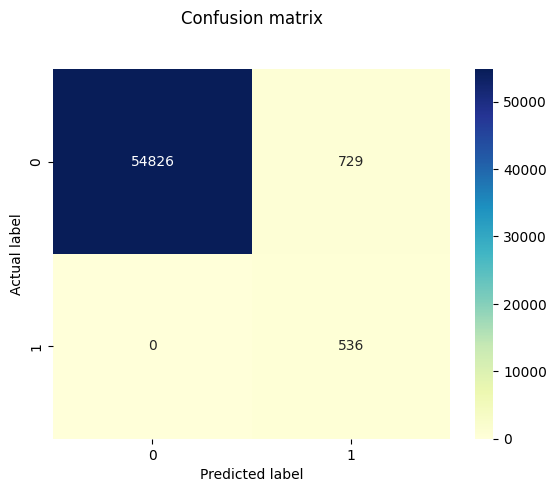

In [128]:
sb.heatmap(pd.DataFrame(cf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

### Run the classifer against the test data

In [138]:
## Load raw data into dataframe
test_df = pd.read_csv('../data/raw/test.csv', low_memory=False)

## pop targets and player num
test_ids = test_df.pop('player_id').to_frame()

## preprocessing steps
test_clean = remove_unwanted_cols(test_df)
test_clean = fillna(test_clean)

In [133]:
# Apply the pipeline
test_pred = clf.predict_proba(test_clean)

c:\Users\Ivan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:227: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [134]:
# Round predicted values to 2 decimal places
test_pred_drafted = np.round(test_pred[:, 1], 2)

In [140]:
test_ids['drafted'] = test_pred_drafted

In [143]:
test_ids.to_csv('../data/processed/submission.csv', index=False)